In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm

# Modeling Home Runs
In (fantasy) baseball, it's important to be able to evaluate trades. However, the typical ESPN analytical toolset includes no player stat projections for the rest of the season. Other projections available online simply extrapolate the current value of a stat like Home Runs to the number of games remaining, which can lead to wildly inaccurate estimates, especially early in the season. 

My goal here is to create a better tool for predicting the number of home runs that a player will hit. Ultimately, I want to tie in data from the MySportsFeeds API and be able to select a player and get a projection of Home Runs for the remainder of the year. In this first exploratory notebook, however, I'm going to use some fabricated data instead of pulling information from the API.


To simplify, let's model home runs for the rest of the season for one fictional player. Say, Michelle Raibowtrout

## Distribution of possible HR values



There are many potential values that the number of home runs could take. Thus, the future homeruns can be considered a *random variable*. What kind of distribution would we expect this random variable to have?

Well, home runs will come in discrete values, so that's our first clue. It could be that a **Poisson distribution** is the proper fit here. Let's check our assumptions!

#### Assumptions and validity
From Wikipedia:

>The Poisson distribution is an appropriate model if the following assumptions are true.

>- k is the number of times an event occurs in an interval and k can take values 0, 1, 2, ....
>- The occurrence of one event does not affect the probability that a second event will occur. That is, events occur independently.
>- The average rate at which events occur is constant.
>- Two events cannot occur at exactly the same instant; instead, at each very small sub-interval exactly one event either occurs or does not occur.
Or
>- The actual probability distribution is given by a binomial distribution and the number of trials is sufficiently bigger than the number of successes one is asking about (see Related distributions).

>If these conditions are true, then k is a Poisson random variable, and the distribution of k is a Poisson distribution

Looks like we're dealing with a Poisson random variable!

An event can occur 0, 1, 2, ... times in an interval. The average number of events in an interval is designated $\lambda$  (lambda). $\lambda$  is the event rate, also called the rate parameter. The probability of observing $k$ events in an interval is given by the equation

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/df3b6a7648b33ca3a987b970e4e8a719f888edb5)

where

>- $\lambda$  is the average number of events per interval
>- e is the number 2.71828... (Euler's number) the base of the natural logarithms
>- k takes values 0, 1, 2, ...
>- k! = k × (k − 1) × (k − 2) × ... × 2 × 1 is the factorial of k.
This equation is the probability mass function (PMF) for a Poisson distribution.

## What is lambda?

We have determined that the number of homeruns is a random variable X~Pois($\lambda$). However, we don't know the actual value of lambda! Thus, lamda is another random variable, with *another distribution*. We actually aren't really sure about this one, so let's use some loose assumptions.
- No one is going to his less than 0 home runs per game, so that's going to be our minimum.
- Although it is technically possible to hit an infinite number of home runs, no one has ever hit more than 4 home runs in a single game. For the sake of being conservative, we'll set the upper bound at 4 home runs per game. This is a very conservative assumption, and could be narrowed down to improve the model.

## Define the model

In [38]:
#Define a model with pymc3
#define an RV with prior distribution called "theta" (our lambda RV)
#define an RV for the home runs

with pm.Model() as model:
    #lambda is reserved in python, so we will call it theta
    theta = pm.Uniform("hr_lambda", 0, 4)
    generator = pm.Poisson("generator", theta)

Now that we have a model for the home run rate, let's take a look at the distribution of potential values that lambda could take on.

/home/lubuntu/anaconda3/envs/bayesball/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.23015692, 0.28769615, 0.26017739, 0.23265863, 0.23265863,
        0.24766886, 0.26267909, 0.27768933, 0.21014328, 0.26017739]),
 array([8.46083861e-04, 4.00573365e-01, 8.00300646e-01, 1.20002793e+00,
        1.59975521e+00, 1.99948249e+00, 2.39920977e+00, 2.79893705e+00,
        3.19866433e+00, 3.59839161e+00, 3.99811890e+00]),
 <a list of 10 Patch objects>)

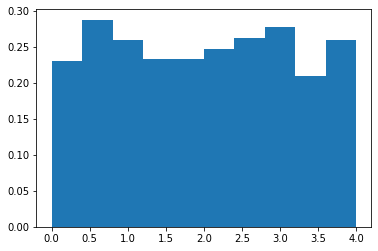

In [39]:
#take sample from the lambda distribution
#plot those samples to show the prior distribution
samples = theta.random(size = 1000)
plt.hist(samples, bins=10, normed=True)


## Observe some data
Now that our model is ready, how can we incorporate observed data?
Here is where the API will come into play in the full version. We will need to know how many home runs a player hits in each game. For Michelle, we'll say that she has hit 11 home runs in 13 games since being called up to The Bigs. Wow!


In [40]:
#given some data
#update our observations for the home runs RV
obs = [1,0,1,1,1,1,0,2,2,0,1,1,0]
generator.observed = obs

Now, let's run a Monte-Carlo Markov Chain simulation of 1000 different trials. We can use the last half of them only if we want, after "convergence" has hopefully occurred.

In [26]:
with model:
    trace = pm.sample(1000)
    burned_trace = trace[500:]

# plt.hist(burned_trace["generator"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [hr_lambda]
100%|██████████| 1500/1500 [00:01<00:00, 918.18it/s]


We now have an updated distribution of possible lambda values, representing potential home run/game rates!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1787a6b390>,
      dtype=object)

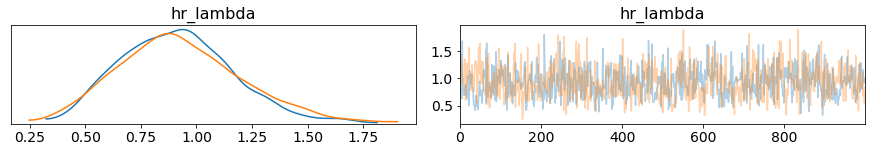

In [28]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17878c70b8>],
      dtype=object)

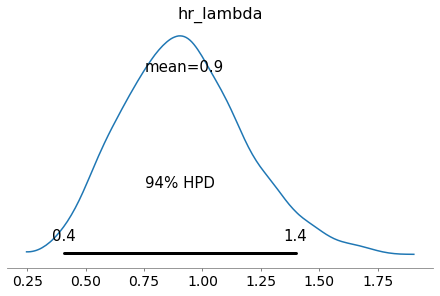

In [29]:
pm.plot_posterior(trace)

Now that we have an updated distribution for values that lambda may be, how does that translate into home runs for the rest of the season? Can we simply multiply the mean lambda value times the number of remaining games?

That's a start, but not quite right. We want to multiply the *distribution* by the number of games left, not just the mean. This way, we have an idea of the possible range of values.

Let's take a look at what's in our model again.

In [30]:
model

### Big picture side note:

We want to know the likely number of home runs that will be hit. Home runs is a random variable distributed by the Poisson distribution. However, the **expected value** of X~Pois($\lambda$) *is* $\lambda$! So __the distribution of lambda should be the distribution of our expected value__.

## Deterministic Variables

Instead of multiplying the `mean value of lambda * games remaining`, we need to create a deterministic variable that is `lamda * games remaining`. This will give us the actual function that we want. We can use the pymc3 'Deterministic' characteristic to add this to our model.

While we're at it, let's go ahead and say how many games there are left in the season. We'll say that we're coming down the home stretch, and that there are 15 games left!

In [31]:
#the games remaining variable would be pulled from the mysportsfeeds API
games_remaining = 15

#add the deterministic variable for rest of season home runs to our model
with model:
    ros_hr = pm.Deterministic('ros_hr', theta*games_remaining)


In [32]:
#take a look at what's going into our rest of season home runs RV
ros_hr

ros_hr

Now that we've added a variable that will measure the number of home runs for the rest of the season, let's run another MCMC simulation.

In [33]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [hr_lambda]
100%|██████████| 1500/1500 [00:01<00:00, 947.27it/s] 


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f178c60bf60>,
      dtype=object)

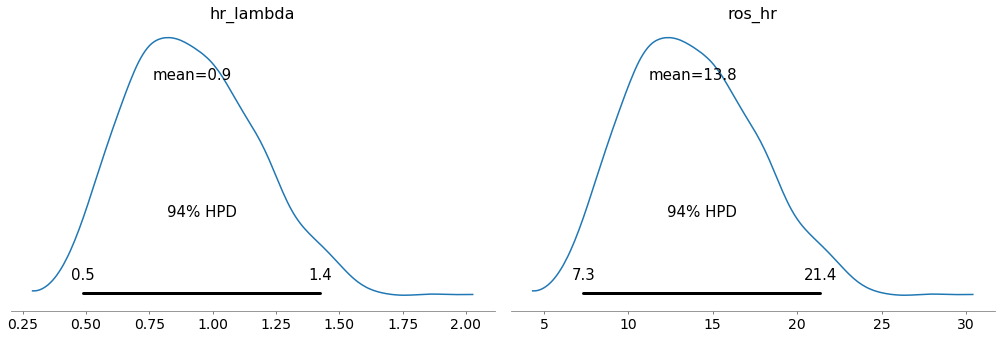

In [34]:
#take a look at the posterior values for our model once again
pm.plot_posterior(trace)

Great! we can see that we indeed did get a reasonable estimate for the number of home runs that Michelle will hit over the next 15 games! It looks like it will be between 7 and 21, most likely around 14. I want her on my fantasy team!